<a href="https://colab.research.google.com/github/kaz2ngt/colaboratory/blob/master/10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リストPART2

In [0]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

# 10_1: 低解像度の画像の生成

In [0]:
def drop_resolution(x, scale=3.0):
  size = (x.shape[0], x.shape[1])
  small_size = (int(size[0]/scale), int(size[1]/scale))
  img = array_to_img(x)
  small_img = img.resize(small_size, 3)
  return img_to_array(small_img.resize(img.size, 3))

# 10_2: ジェネレータの定義

In [0]:
def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
  for imgs in ImageDataGenerator().flow_from_directory(
      directory=data_dir,
      classes=[mode],
      class_mode=None,
      color_mode='rgb',
      target_size=target_size,
      batch_size=batch_size,
      shuffle=shuffle
  ):
      x = np.array([
          drop_resolution(img, scale) for img in imgs
      ])
      yield x/255., imgs/255.

# 10_3: data_generatorの利用

In [0]:
# dataの解凍
#!unzip data.zip

In [27]:
DATA_DIR = 'data/chap10/'
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 32

train_data_generator = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)
test_x, test_y = next(
    data_generator(
        DATA_DIR,
        'test',
        batch_size=N_TEST_DATA,
        shuffle=False
    )
)

Found 100 images belonging to 1 classes.


# 10_4: SRCNNの定義

In [28]:
model = Sequential()
model.add(Conv2D(
    filters=64,
    kernel_size=9,
    padding='same',
    activation='relu',
    input_shape=(None, None, 3)
))
model.add(Conv2D(
    filters=32,
    kernel_size=1,
    padding='same',
    activation='relu'
))
model.add(Conv2D(
    filters=3,
    kernel_size=5,
    padding='same'
))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


# 10_5: ピーク信号対雑音比の定義

In [0]:
def psnr(y_true, y_pred):
  return -10*K.log(
      K.mean(K.flatten((y_true - y_pred))**2)
  )/np.log(10)

# 10_6: PSNRをmetricsに指定して学習を実行

In [30]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# テストデータに対して適用
pred = model.predict(test_x)

Found 1000 images belonging to 1 classes.
Epoch 1/50
31/31 [==============================] - 7s 222ms/step - loss: 0.0236 - psnr: 17.2557 - val_loss: 0.0134 - val_psnr: 18.9389
Epoch 2/50
31/31 [==============================] - 6s 181ms/step - loss: 0.0089 - psnr: 20.5412 - val_loss: 0.0098 - val_psnr: 20.3399
Epoch 3/50
31/31 [==============================] - 6s 181ms/step - loss: 0.0070 - psnr: 21.5977 - val_loss: 0.0085 - val_psnr: 20.9766
Epoch 4/50
31/31 [==============================] - 6s 181ms/step - loss: 0.0064 - psnr: 22.0185 - val_loss: 0.0078 - val_psnr: 21.3590
Epoch 5/50
31/31 [==============================] - 6s 180ms/step - loss: 0.0059 - psnr: 22.3544 - val_loss: 0.0074 - val_psnr: 21.6320
Epoch 6/50
31/31 [==============================] - 6s 181ms/step - loss: 0.0058 - psnr: 22.3951 - val_loss: 0.0072 - val_psnr: 21.7619
Epoch 7/50
31/31 [==============================] - 6s 181ms/step - loss: 0.0052 - psnr: 22.8967 - val_loss: 0.0073 - val_psnr: 21.6603
Epoch 

# 10_7: モデルの構築

In [0]:
from tensorflow.python.keras.layers import Add, Conv2DTranspose

# 入力は任意のサイズで、3チャンネルの画像
inputs = Input((None, None, 3), dtype='float')

# Encoder
conv1 = Conv2D(64, 3, padding='same')(inputs)
conv1 = Conv2D(64, 3, padding='same')(conv1)

conv2 = Conv2D(64, 3, strides=2, padding='same')(conv1)
conv2 = Conv2D(64, 3, padding='same')(conv2)

conv3 = Conv2D(64, 3, strides=2, padding='same')(conv2)
conv3 = Conv2D(64, 3, padding='same')(conv3)

# Decoder
deconv3 = Conv2DTranspose(64, 3, padding='same')(conv3)
deconv3 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv3)

# Add() レイヤーを使ってスキップコネクションを表現
merge2 = Add()([deconv3, conv2])
deconv2 = Conv2DTranspose(64, 3, padding='same')(merge2)
deconv2 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv2)
merge1 = Add()([deconv2, conv1])
deconv1 = Conv2DTranspose(64, 3, padding='same')(merge1)
deconv1 = Conv2DTranspose(3, 3, padding='same')(deconv1)

output = Add()([deconv1, inputs])

model = Model(inputs, output)

In [32]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# テストデータに対して適用
pred2 = model.predict(test_x)

Epoch 1/50
31/31 [==============================] - 26s 833ms/step - loss: 0.0498 - psnr: 19.0584 - val_loss: 0.0062 - val_psnr: 22.4397
Epoch 2/50
31/31 [==============================] - 23s 742ms/step - loss: 0.0043 - psnr: 23.7348 - val_loss: 0.0054 - val_psnr: 23.0492
Epoch 3/50
31/31 [==============================] - 23s 742ms/step - loss: 0.0038 - psnr: 24.2905 - val_loss: 0.0052 - val_psnr: 23.2707
Epoch 4/50
31/31 [==============================] - 23s 742ms/step - loss: 0.0037 - psnr: 24.4029 - val_loss: 0.0052 - val_psnr: 23.2737
Epoch 5/50
31/31 [==============================] - 23s 743ms/step - loss: 0.0038 - psnr: 24.2815 - val_loss: 0.0050 - val_psnr: 23.4349
Epoch 6/50
31/31 [==============================] - 23s 741ms/step - loss: 0.0037 - psnr: 24.4471 - val_loss: 0.0050 - val_psnr: 23.3914
Epoch 7/50
31/31 [==============================] - 23s 740ms/step - loss: 0.0035 - psnr: 24.6650 - val_loss: 0.0049 - val_psnr: 23.4840
Epoch 8/50
31/31 [=======================

# 番外: スキップコネクションを利用しない

In [0]:
from tensorflow.python.keras.layers import Add, Conv2DTranspose

# 入力は任意のサイズで、3チャンネルの画像
inputs = Input((None, None, 3), dtype='float')

# Encoder
conv1 = Conv2D(64, 3, padding='same')(inputs)
conv1 = Conv2D(64, 3, padding='same')(conv1)

conv2 = Conv2D(64, 3, strides=2, padding='same')(conv1)
conv2 = Conv2D(64, 3, padding='same')(conv2)

conv3 = Conv2D(64, 3, strides=2, padding='same')(conv2)
conv3 = Conv2D(64, 3, padding='same')(conv3)

# Decoder
deconv3 = Conv2DTranspose(64, 3, padding='same')(conv3)
deconv3 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv3)

# スキップコネクションを利用しない
deconv2 = Conv2DTranspose(64, 3, padding='same')(deconv3)
deconv2 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv2)
deconv1 = Conv2DTranspose(64, 3, padding='same')(deconv2)
deconv1 = Conv2DTranspose(3, 3, padding='same')(deconv1)

model = Model(inputs, deconv1)

In [34]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# テストデータに対して適用
pred3 = model.predict(test_x)

Epoch 1/50
31/31 [==============================] - 25s 796ms/step - loss: 0.0877 - psnr: 11.9705 - val_loss: 0.0632 - val_psnr: 11.9952
Epoch 2/50
31/31 [==============================] - 22s 705ms/step - loss: 0.0240 - psnr: 16.5102 - val_loss: 0.0172 - val_psnr: 17.7507
Epoch 3/50
31/31 [==============================] - 22s 708ms/step - loss: 0.0117 - psnr: 19.3706 - val_loss: 0.0127 - val_psnr: 19.1553
Epoch 4/50
31/31 [==============================] - 22s 706ms/step - loss: 0.0092 - psnr: 20.3992 - val_loss: 0.0111 - val_psnr: 19.7646
Epoch 5/50
31/31 [==============================] - 22s 710ms/step - loss: 0.0084 - psnr: 20.7866 - val_loss: 0.0106 - val_psnr: 19.9911
Epoch 6/50
31/31 [==============================] - 22s 706ms/step - loss: 0.0077 - psnr: 21.1568 - val_loss: 0.0093 - val_psnr: 20.5819
Epoch 7/50
31/31 [==============================] - 22s 707ms/step - loss: 0.0068 - psnr: 21.7015 - val_loss: 0.0087 - val_psnr: 20.8630
Epoch 8/50
31/31 [=======================

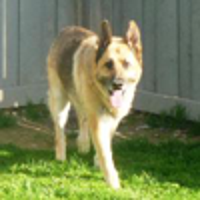

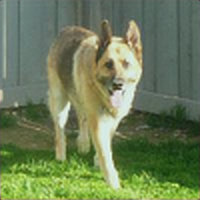

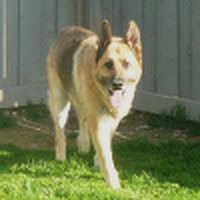

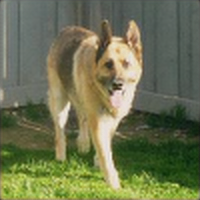

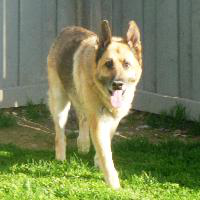

-------------------------


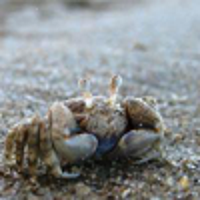

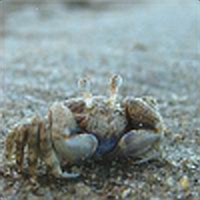

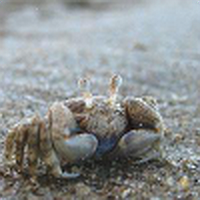

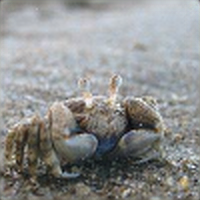

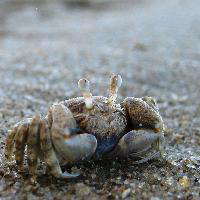

-------------------------


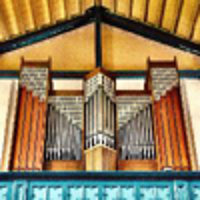

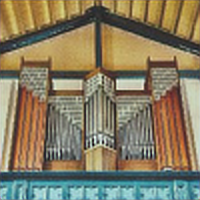

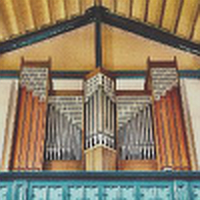

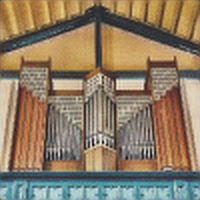

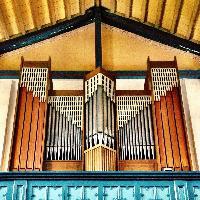

-------------------------


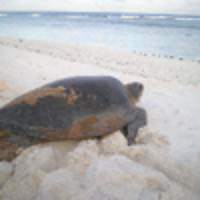

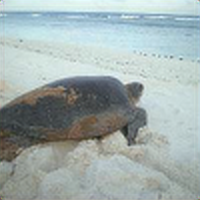

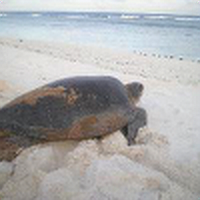

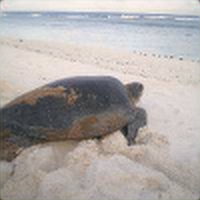

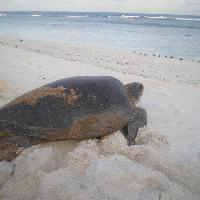

-------------------------


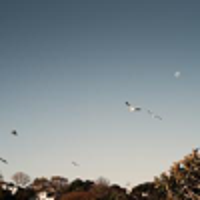

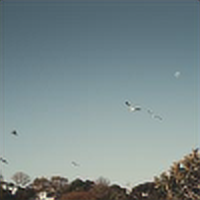

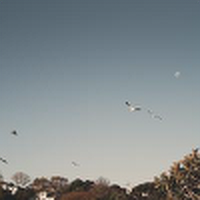

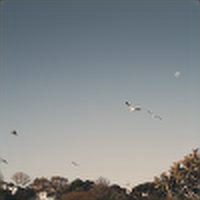

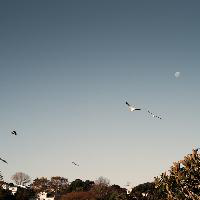

-------------------------


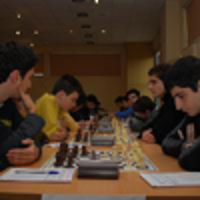

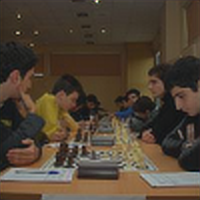

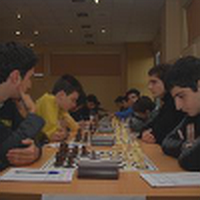

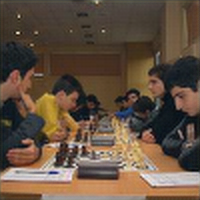

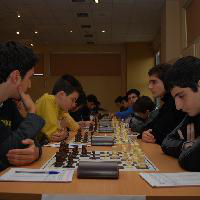

-------------------------


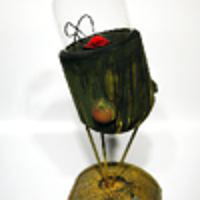

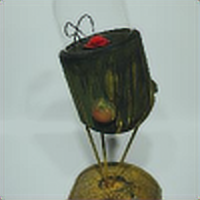

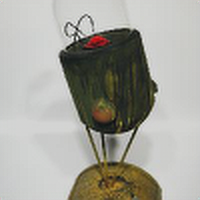

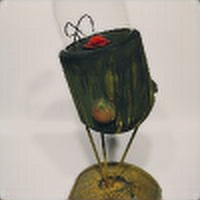

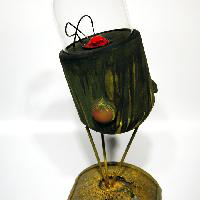

-------------------------


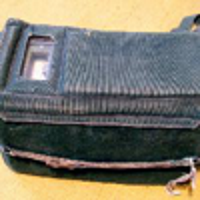

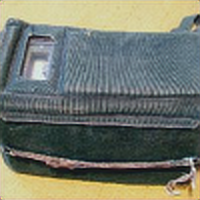

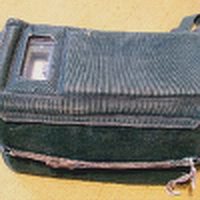

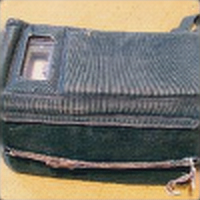

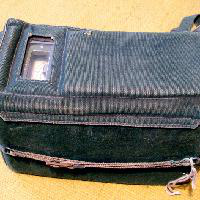

-------------------------


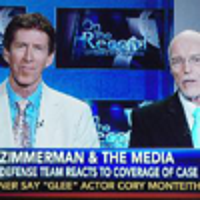

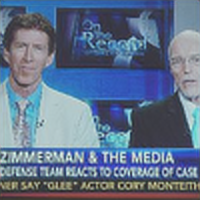

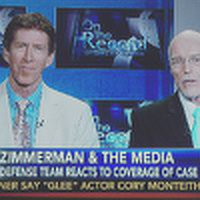

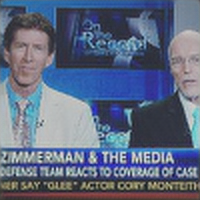

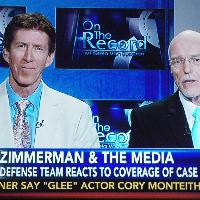

-------------------------


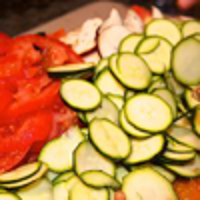

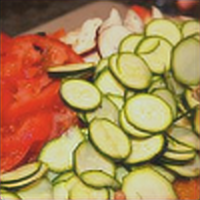

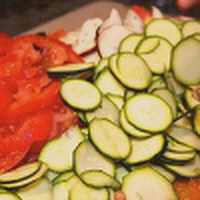

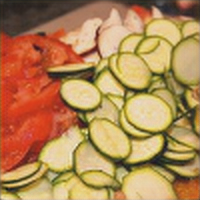

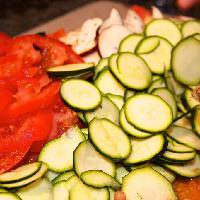

-------------------------


In [35]:
from IPython.display import display_png

for i in range(10):
    display_png(array_to_img(test_x[i]))
    display_png(array_to_img(pred[i]))
    display_png(array_to_img(pred2[i]))
    display_png(array_to_img(pred3[i]))
    display_png(array_to_img(test_y[i]))
    print('-' * 25)